<a href="https://colab.research.google.com/github/OksanaSitalova/PYTHON-Restaurant-Analysis/blob/main/Restaurant_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import files
# uploaded = files.upload()


# Data extraction and merging:

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Establishing a connection to the 'db_new.sqlite3' database
conn = sqlite3.connect('db_new.sqlite3')

# SQL query: select the names of all tables in the database
# 'sqlite_master' is an internal SQLite table that stores the database schema
# WHERE type='table' filters only the records that represent actual tables (excluding e.g. indexes)
query = "SELECT name FROM sqlite_master WHERE type='table';"

# Executing the query and reading the result into a DataFrame using pandas
df = pd.read_sql(query, conn)

# Displaying the list of tables in the database
print("Tables in the database:")
print(df)

Tables in the database:
                   name
0       sqlite_sequence
1  restaurant_orderitem
2    restaurant_product
3      restaurant_order


In [ ]:
# Loop through the list of tables we want to inspect
for table_name in ['restaurant_orderitem', 'restaurant_product', 'restaurant_order']:

    # Print the name of the current table
    print(f"\n📄 Table: {table_name}")

    # Execute an SQL query to read all data from the current table into a DataFrame
    df = pd.read_sql(f"SELECT * FROM {table_name}", conn)

    # Display the first 5 rows of the table to review its structure and sample data
    print(df.head())


📄 Table: restaurant_orderitem
   id  quantity  order_id  product_id
0   1         2         1           6
1   2         1         1         240
2   3         1         1          19
3   4         1         1          36
4   5         1         1         111

📄 Table: restaurant_product
   id  price           name
0   1    0.5     Mint Sauce
1   2    0.5    Lime Pickle
2   3    0.5  Mango Chutney
3   4    0.5      Red Sauce
4   5    0.5  Onion Chutney

📄 Table: restaurant_order
   id             datetime
0   1  2019-08-03 20:25:00
1   2  2019-08-03 20:17:00
2   3  2019-08-03 20:09:00
3   4  2019-08-03 20:01:00
4   5  2019-08-03 19:44:00


In [ ]:
# Define a SQL query to join three tables:
# - restaurant_orderitem: contains individual items in each order
# - restaurant_order: contains order-level information (like datetime)
# - restaurant_product: contains product details like name and price

query = """
SELECT
    oi.order_id,                 -- ID of the order
    o.datetime,                 -- Date and time when the order was placed
    p.name AS product_name,     -- Name of the product
    p.price,                    -- Price of a single unit of the product
    oi.quantity                 -- Quantity of the product in the order
FROM restaurant_orderitem oi
JOIN restaurant_order o ON oi.order_id = o.id             -- Join orders
JOIN restaurant_product p ON oi.product_id = p.id         -- Join products
ORDER BY o.datetime DESC                                  -- Sort by most recent orders
"""

# Execute the SQL query and read the result into a pandas DataFrame
restaurant = pd.read_sql(query, conn)

# Show the structure and data types of the resulting DataFrame
restaurant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74818 entries, 0 to 74817
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   order_id      74818 non-null  int64  
 1   datetime      74818 non-null  object 
 2   product_name  74818 non-null  object 
 3   price         74818 non-null  float64
 4   quantity      74818 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 2.9+ MB


In [ ]:
# Save the current DataFrame to a CSV file without the index column
restaurant.to_csv('restaurant.csv', index=False)

# Read the CSV file back into a new DataFrame (simulating a fresh load)
restaurant = pd.read_csv('restaurant.csv')

restaurant.head()
restaurant.describe()

,order_id,price,quantity
count,74818.000000,74818.000000,74818.000000
mean,5756.303563,5.267512,1.243564
std,3745.827156,3.325707,0.798207
min,1.000000,0.500000,1.000000
25%,2461.000000,2.950000,1.000000
50%,5308.000000,3.950000,1.000000
75%,8913.000000,8.950000,1.000000
max,13397.000000,17.950000,51.000000


In [ ]:
# Changing data types for the appropriate columns
restaurant['datetime'] = pd.to_datetime(restaurant['datetime'])  # object → datetime64
restaurant['price'] = restaurant['price'].astype('float16')      # float64 → float16
restaurant['quantity'] = restaurant['quantity'].astype('int16')  # int64 → int16
restaurant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74818 entries, 0 to 74817
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   order_id      74818 non-null  int64         
 1   datetime      74818 non-null  datetime64[ns]
 2   product_name  74818 non-null  object        
 3   price         74818 non-null  float16       
 4   quantity      74818 non-null  int16         
dtypes: datetime64[ns](1), float16(1), int16(1), int64(1), object(1)
memory usage: 2.0+ MB


# Top 10 most popular products by quantity:

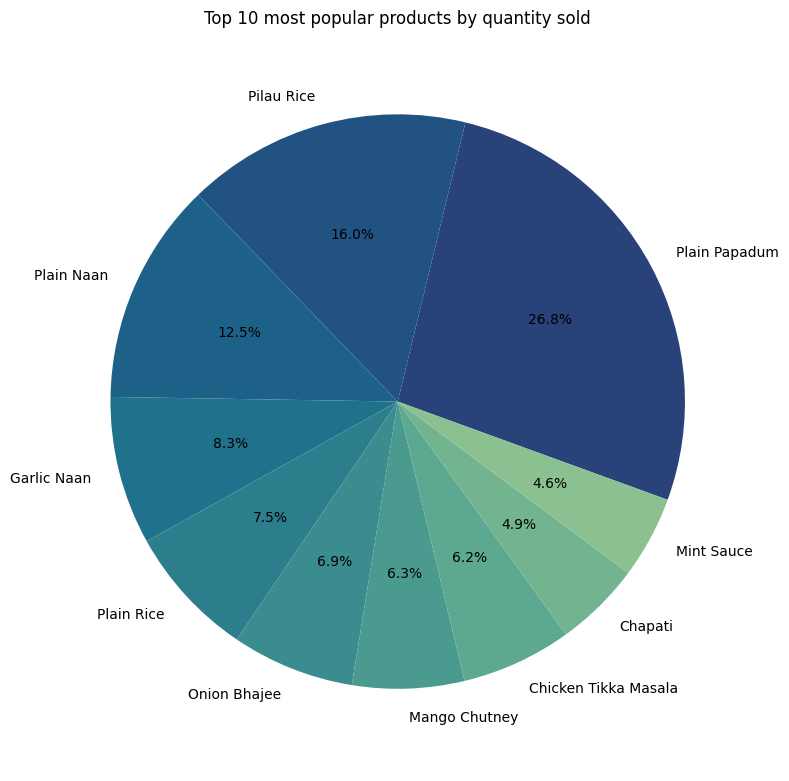

In [ ]:
# Group by product_name and calculate the total quantity sold
top10 = (restaurant.groupby('product_name', as_index=False)['quantity'].sum().sort_values(by='quantity', ascending=False).head(10))

# Create a color palette (10 colors)
colors = sns.color_palette("crest_r", n_colors=10)


# Build the pie chart
plt.figure(figsize=(8, 8))

plt.pie(
    top10['quantity'],             # Values to plot
    labels=top10['product_name'],  # Labels
    autopct='%1.1f%%',             # Show percentages
    startangle=340,                # Start angle
    colors=colors)                  # Correct use of the color palette


plt.title('Top 10 most popular products by quantity sold')
plt.axis('equal')
plt.tight_layout()
plt.show()

Most Popular Product: Plain Papadum (≈ 26.8% of all sales among the top 10).
This indicates high popularity or that it is frequently ordered as a side dish.

Pilau Rice (≈ 16.0%) and Plain Naan (≈ 12.5%) rank second and third, respectively.
These are classic side dishes, likely ordered in almost every other order.

Products like Garlic Naan, Plain Rice, Mango Chutney have a similar level of popularity (6–8%).

The least ordered in the top 10 were:
Chapati (≈ 4.9%)
Mint Sauce (≈ 4.6%)
This could be due to less active promotion or the availability of better alternatives.

What this means for the restaurant:

It is worth maintaining Plain Papadum, Pilau Rice, and Plain Naan in constant availability — they generate the highest number of sales.

Chapati and Mint Sauce can be checked for:

low demand,
possible replacement or optimization of ingredients,
testing new promotions or combos.

# Top 10 most profitable products by unit price:

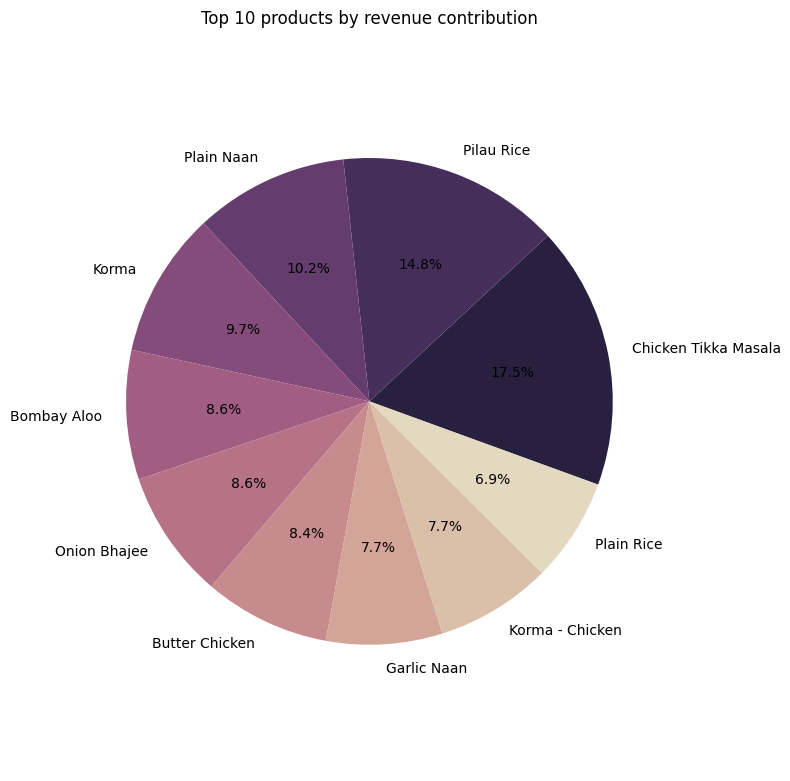

In [ ]:
# Calculate revenue for each product in each order (price * quantity)
restaurant["item_price"] = restaurant["price"] * restaurant["quantity"]

# Group data by product name and calculate total revenue per product
top_revenue = (restaurant.groupby('product_name', as_index=False)['item_price'].sum().sort_values(by='item_price', ascending=False).head(10))

# Create a color palette for the pie chart (10 colors)
colors = sns.color_palette("ch:s=-.2,r=.6_r", n_colors=10)

# Set the figure size for the chart
plt.figure(figsize=(8, 8))

# Create the pie chart
plt.pie(
    top_revenue['item_price'],             # Revenue values to plot
    labels=top_revenue['product_name'],    # Product names as labels
    autopct='%1.1f%%',                     # Show percentages with one decimal
    startangle=340,                        # Starting rotation angle
    colors=colors                          # Apply the color palette
)

# Add a title to the chart
plt.title('Top 10 products by revenue contribution')

# Make the chart a circle (equal axis proportions)
plt.axis('equal')

# Adjust layout to prevent clipping
plt.tight_layout()

# Display the chart
plt.show()

Key Observations:

The highest revenue for the restaurant comes from Chicken Tikka Masala – 17.5% of the total revenue in the top 10.
This is the main "star of the menu" — it should be actively promoted, included in combo deals, or maintained as a premium offering.

Pilau Rice (14.8%) and Plain Naan (10.2%) rank second and third.
Side dishes and bread contribute a significant portion of the revenue, even though they may cost less than main courses.

Other items with a fairly even distribution of revenue (~7–9%):
Korma, Bombay Aloo, Onion Bhajee, Butter Chicken, Garlic Naan
These are stable, well-selling items, but not "top generators."

Plain Rice (6.9%) — although a side dish, it has a smaller financial contribution compared to other products.
It is possibly often sold at a reduced price or as part of set meal orders.

Business Conclusions:

Chicken Tikka Masala is the main revenue driver.
It is worth:

Advertising it as "recommended,"
Creating promotions (but without discounting the item itself),
Promoting it as a key delivery item.
Revenue does not equal the number of sales: products with a lower order frequency can bring in more money (because they are more expensive).

It is wise to focus staff, inventory, and advertising on dishes with a high revenue contribution.

# Revenue analysis by hour:


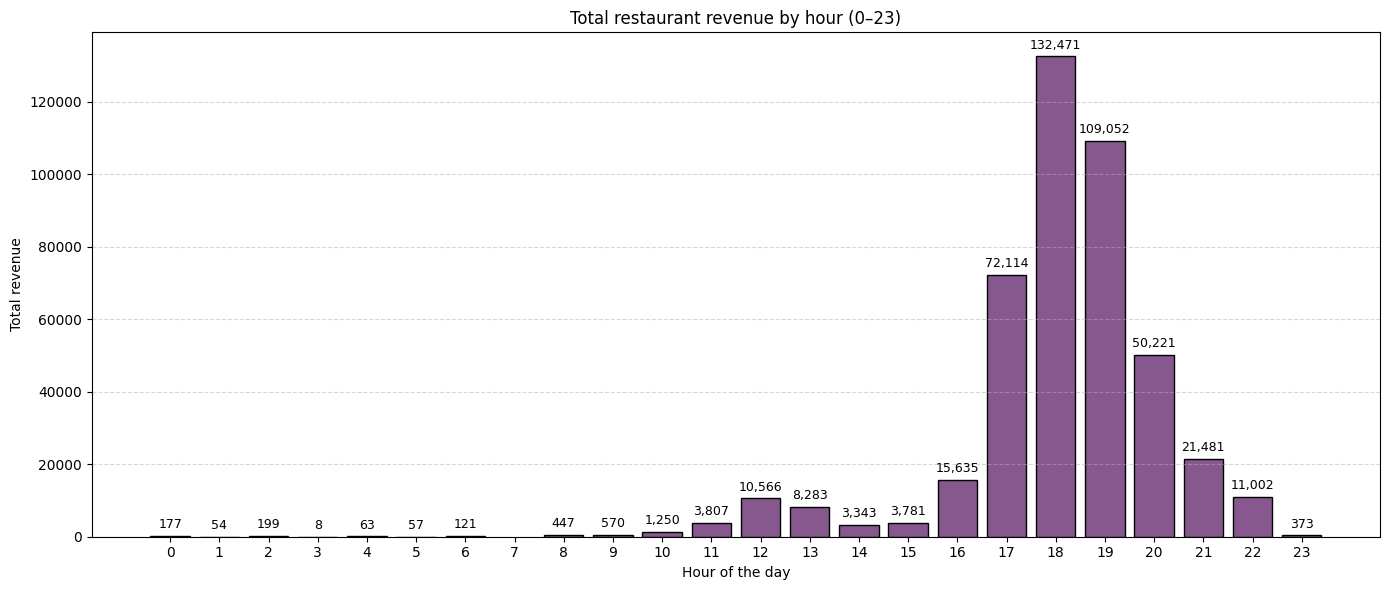

In [ ]:
restaurant["hour"] = restaurant["datetime"].dt.hour

# Group by hour and calculate total revenue
hourly_revenue = (restaurant.groupby("hour", as_index=False)["item_price"].sum().rename(columns={"item_price": "total_revenue"}))

plt.figure(figsize=(14, 6))

bars = plt.bar(hourly_revenue["hour"], hourly_revenue["total_revenue"], color="#87588E", edgecolor="black")

# Add value labels above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,            # Center of the bar
        height + max(hourly_revenue["total_revenue"]) * 0.01,  # Slightly above
        f'{int(height):,}',                           # Format: integer with thousand separators
        ha='center',
        va='bottom',
        fontsize=9,
        color='black'
    )

# Chart formatting
plt.xlabel("Hour of the day")
plt.ylabel("Total revenue")
plt.title("Total restaurant revenue by hour (0–23)")
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Hours with Peak Revenue:

6:00 PM (18:00) — Absolute Peak: 132,471
7:00 PM (19:00) — Second Highest: 109,052
5:00 PM (17:00) — Also Very Active: 72,114
These three hours represent the evening prime time. This is when the most orders are placed and the highest revenue is generated.

Decrease After 8:00 PM (20:00):

Revenue gradually decreases after 8:00 PM:

8:00 PM (20:00) → 50,221
9:00 PM (21:00) → 21,481
10:00 PM (22:00) → 11,002
11:00 PM (23:00) → Only 373
This indicates that customer activity drops sharply after 8:00 PM.

Low Activity Before Lunch:

Before 11:00 AM — very low figures (almost zero)
After 12:00 PM — gradual increase
This is a typical distribution for restaurants that focus on lunch and dinner service.

Recommendations:

Maximum staff, kitchen, and delivery personnel should be scheduled for 5:00 PM – 7:00 PM (17:00–19:00).
Morning hours (before 10:00 AM) are inefficient for sales: this time can be used for preparation, deliveries, etc.
After 9:00 PM (21:00) — revenue drops sharply → it may not be worth operating late.


# Revenue analysis by day of the week:

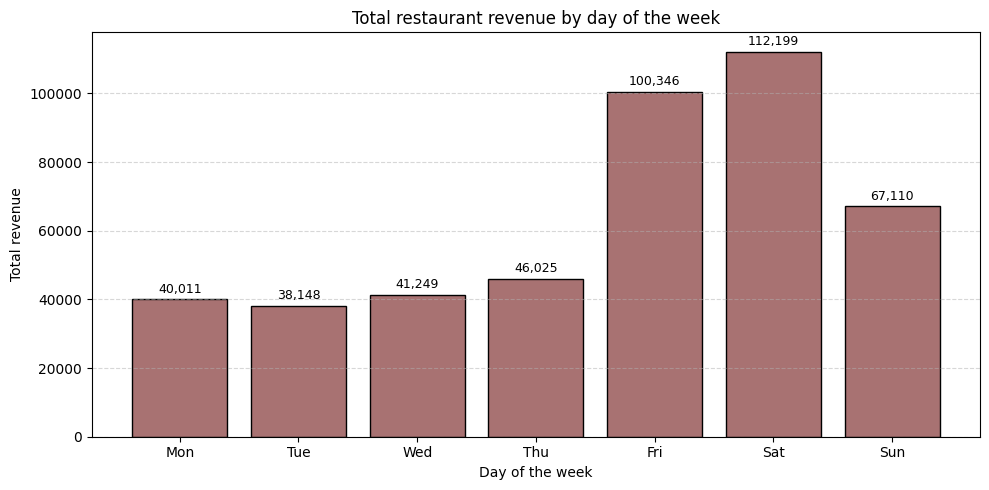

In [ ]:
restaurant["weekday"] = restaurant["datetime"].dt.dayofweek

# Group by day of the week
weekly_revenue = (restaurant.groupby("weekday", as_index=False)["item_price"].sum()
.rename(columns={"item_price": "total_revenue"}))

# Day names in Ukrainian (0 — Mon, 6 — Sun)
day_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

# Add a column with day names
weekly_revenue["day_name"] = weekly_revenue["weekday"].map(lambda x: day_labels[x])

plt.figure(figsize=(10, 5))

# Build the bar chart
bars = plt.bar(weekly_revenue["day_name"],weekly_revenue["total_revenue"], color="#A87272", edgecolor="black")

# Add value labels above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,           # Center of the bar
        height + max(weekly_revenue["total_revenue"]) * 0.01,  # Slightly above the bar
        f'{int(height):,}',                          # Format: integer with thousand separators
        ha='center',
        va='bottom',
        fontsize=9,
        color='black')

# Styling
plt.title("Total restaurant revenue by day of the week")
plt.xlabel("Day of the week")
plt.ylabel("Total revenue")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Key Observations:

Most Profitable Days of the Week:

Saturday (Sat) — Absolute Leader with Revenue: 112,199
Friday (Fri) — Second Highest: 100,346
Sunday (Sun) — Third Highest: 67,110
This is classic behavior for restaurants — peak activity occurs on weekends and the evenings before the weekend.

Least Profitable Days:

Tuesday (Tue) — Lowest Revenue: 38,148
Monday (Mon) — Only Slightly Better: 40,011
The beginning of the week is a period of low restaurant activity, possibly due to customers' financial restraint or workload.

Wednesday and Thursday — Average Level:

Wednesday (Wed): 41,249
Thursday (Thu): 46,025
A gradual increase is observed leading up to Friday.

Recommendations:

Actively plan promotions, advertising, and main sales for Friday–Sunday.
🧘‍♀️ Monday–Tuesday are good days for:
Internal training,
Menu updates,
Technical maintenance.
It is worth testing promotions on Tuesday to "boost" the weakest day of the week.

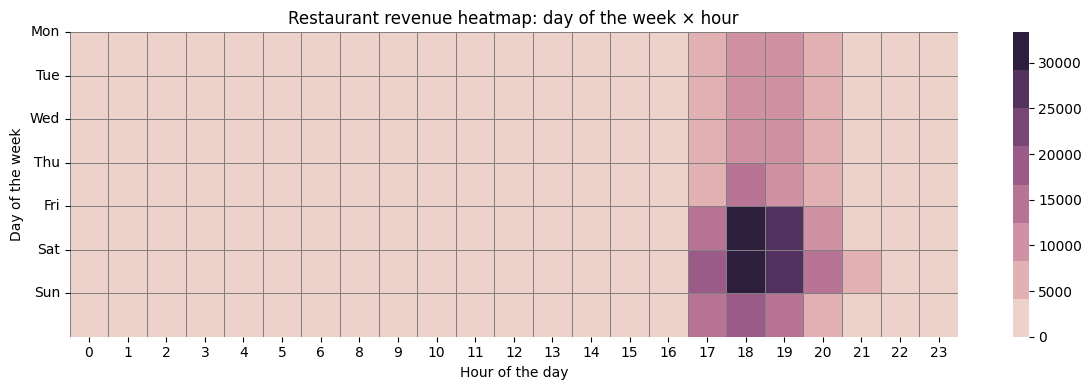

In [ ]:
# Pivot table: day × hour
pivot = restaurant.pivot_table(
    values="item_price",
    index="weekday",
    columns="hour",
    aggfunc="sum",
    fill_value=0
)
palette = sns.cubehelix_palette(8)
plt.figure(figsize=(12, 4))
sns.heatmap(pivot, cmap=palette, linewidths=0.5, linecolor="gray")

# Axis labels and chart title
plt.title("Restaurant revenue heatmap: day of the week × hour")
plt.xlabel("Hour of the day")
plt.ylabel("Day of the week")
plt.yticks(
    ticks=range(7),
    labels=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    rotation=0
)

plt.tight_layout()
plt.show()

Main traffic is concentrated between 5:00 PM – 7:00 PM (17:00–19:00), Friday-Saturday-Sunday.

These hours need to be maximally reinforced with kitchen staff, service personnel, and delivery resources.

Low traffic on weekdays during the day.

This time can be used for:

Maintenance,
Staff training,
Evening preparation,
Testing new dishes during quiet hours.
It is wise to launch promotions on Monday–Tuesday evenings to increase traffic on weaker days.